# Exploración de Datos: Letras Estáticas

Este notebook realiza un análisis exploratorio (EDA) sobre el dataset de letras estáticas en Lengua de Señas Mexicana (LSM). Exploramos la distribución de clases, calidad de las imágenes, sus dimensiones, y verificamos su validez para prepararlas para entrenamiento.

In [17]:
from pyprojroot import here
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

# Configuración general
plt.style.use("seaborn-v0_8-whitegrid")

# Cargar dataset
csv_path = here() / "data" / "letters" / "letter_labels.csv"
df = pd.read_csv(csv_path)
df.head()

,image_path,label
0,data/letters/statics/A/S1-A-4-0.jpg,A
1,data/letters/statics/A/S1-A-4-1.jpg,A
2,data/letters/statics/A/S1-A-4-10.jpg,A
3,data/letters/statics/A/S1-A-4-100.jpg,A
4,data/letters/statics/A/S1-A-4-101.jpg,A


## Distribución de Clases

Graficamos cuántas imágenes hay por cada letra del abecedario para identificar posibles desbalances.

C:\Users\Jamin\AppData\Local\Temp\ipykernel_23820\2296821275.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", order=sorted(df['label'].unique()), palette="viridis")


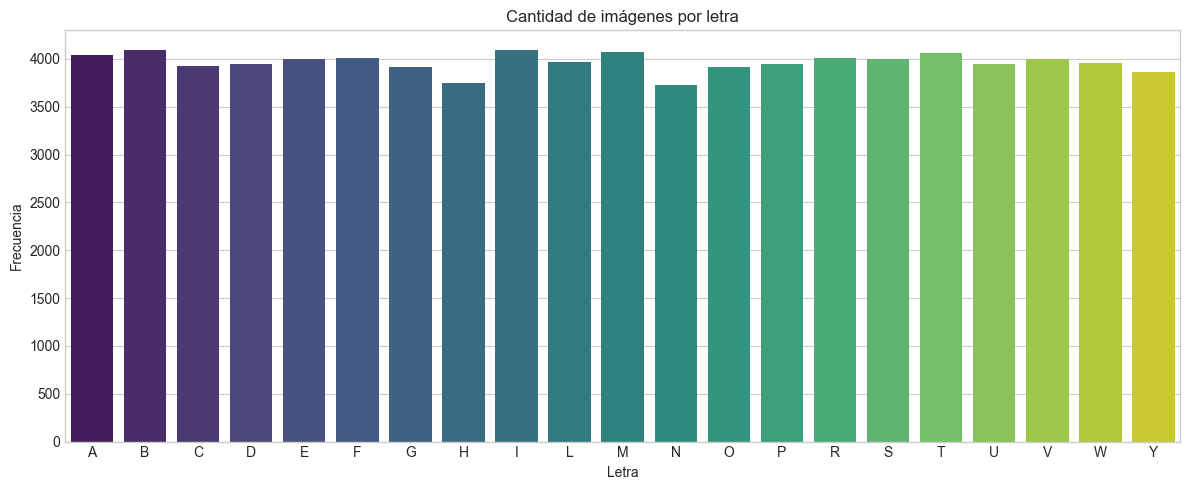

In [18]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x="label", order=sorted(df['label'].unique()), palette="viridis")
plt.title("Cantidad de imágenes por letra")
plt.xlabel("Letra")
plt.ylabel("Frecuencia")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Visualización de muestras

Mostraremos una imagen representativa por cada letra para verificar la calidad y diversidad del dataset.

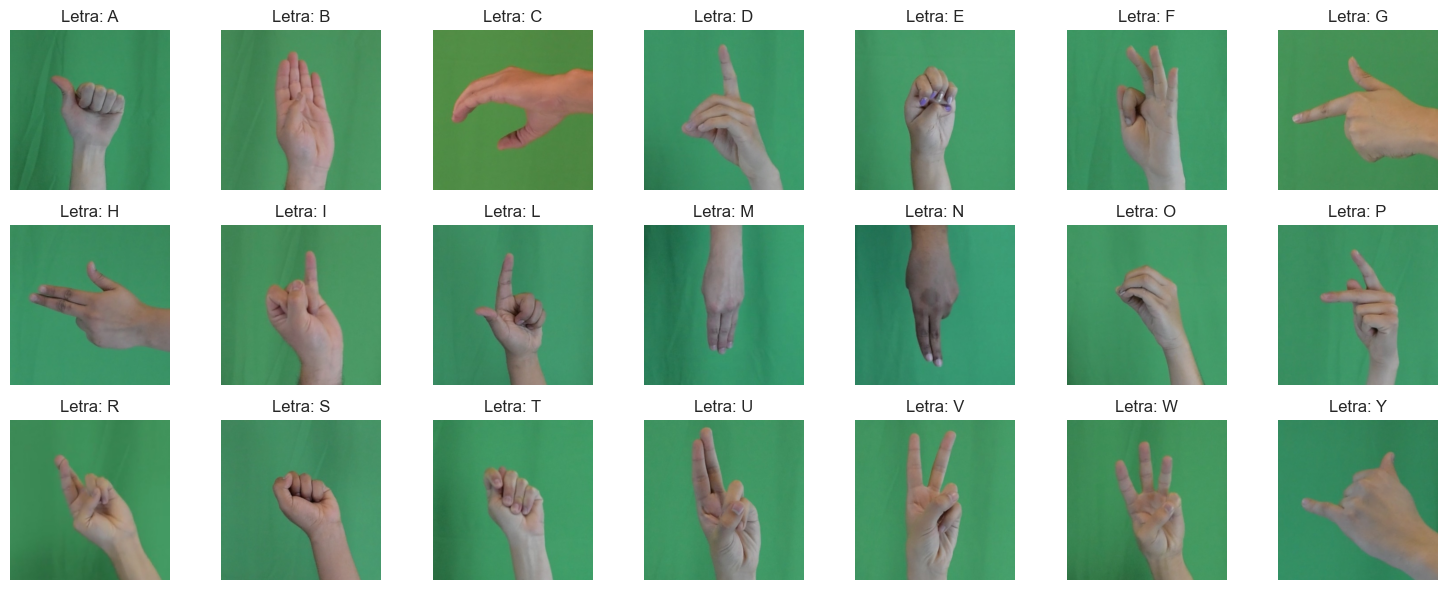

In [19]:
letters = sorted(df['label'].unique())
n = len(letters)

fig, axes = plt.subplots(3, (n + 2) // 3, figsize=(15, 6))
axes = axes.flatten()

for i, letra in enumerate(letters):
    sample_path = df[df['label'] == letra].sample(1)['image_path'].values[0]
    img_path = here() / Path(sample_path)
    
    if not img_path.exists():
        print(f"❌ Imagen no encontrada: {img_path}")
        continue

    img = cv2.imread(str(img_path))
    if img is None:
        print(f"⚠️ Error al cargar: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Letra: {letra}")
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Tamaño de Imágenes

Analizamos las dimensiones de todas las imágenes para ver si necesitan ser redimensionadas.

In [20]:
sizes = []
errores = []

for path in df["image_path"]:
    img_path = here() / path
    img = cv2.imread(str(img_path))
    if img is not None:
        h, w = img.shape[:2]
        sizes.append((w, h))
    else:
        errores.append(str(img_path))

size_df = pd.DataFrame(sizes, columns=["width", "height"])
print(f"✅ {len(size_df)} imágenes cargadas correctamente.")
print(f"❌ {len(errores)} imágenes con error de lectura.")

✅ 83264 imágenes cargadas correctamente.
❌ 0 imágenes con error de lectura.


## Distribución de Tamaños

Visualizamos la distribución de anchos y altos para decidir un tamaño uniforme.

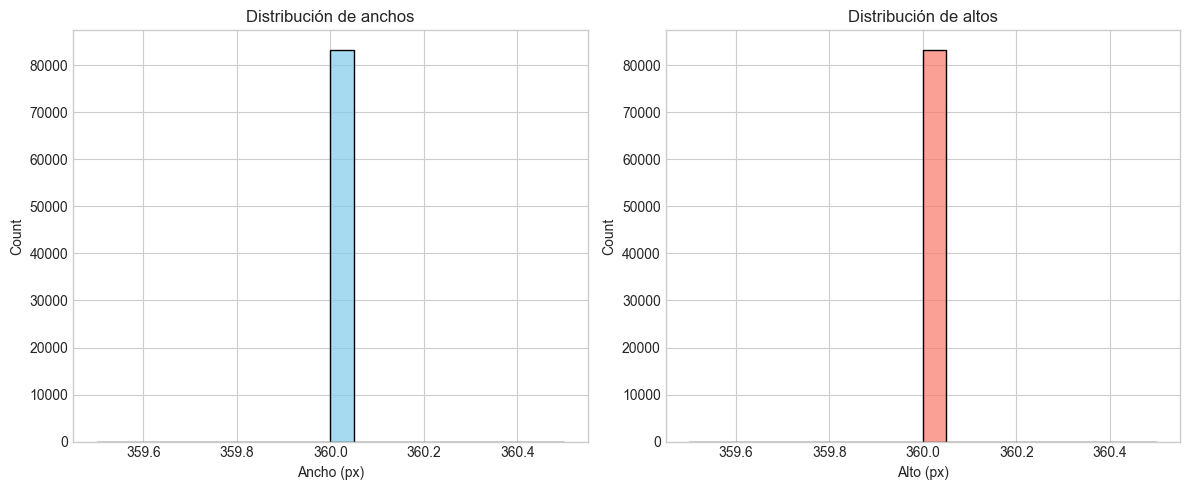

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(size_df["width"], bins=20, kde=False, color="skyblue")
plt.title("Distribución de anchos")
plt.xlabel("Ancho (px)")

plt.subplot(1, 2, 2)
sns.histplot(size_df["height"], bins=20, kde=False, color="salmon")
plt.title("Distribución de altos")
plt.xlabel("Alto (px)")

plt.tight_layout()
plt.show()

In [22]:
# Tamaños unicos Mas Comunes
unique_sizes = size_df.value_counts().reset_index(name="count")
unique_sizes.columns = ["width", "height", "count"]
unique_sizes.head(10)

,width,height,count
0,360,360,83264


## Reducción de dimensionalidad con PCA + UMAP
Para visualizar mejor la distribución y separabilidad entre clases, se aplicó una combinación de PCA (Análisis de Componentes Principales) y UMAP (Uniform Manifold Approximation and Projection). Dado el alto costo computacional de trabajar con imágenes de 360×360 píxeles, se redimensionaron previamente a 64×64 para reducir el consumo de memoria sin perder la forma general de los gestos.

100%|██████████| 83264/83264 [03:02<00:00, 455.94it/s]
c:\Users\Jamin\miniconda3\envs\signml\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jamin\miniconda3\envs\signml\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Jamin\miniconda3\envs\signml\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


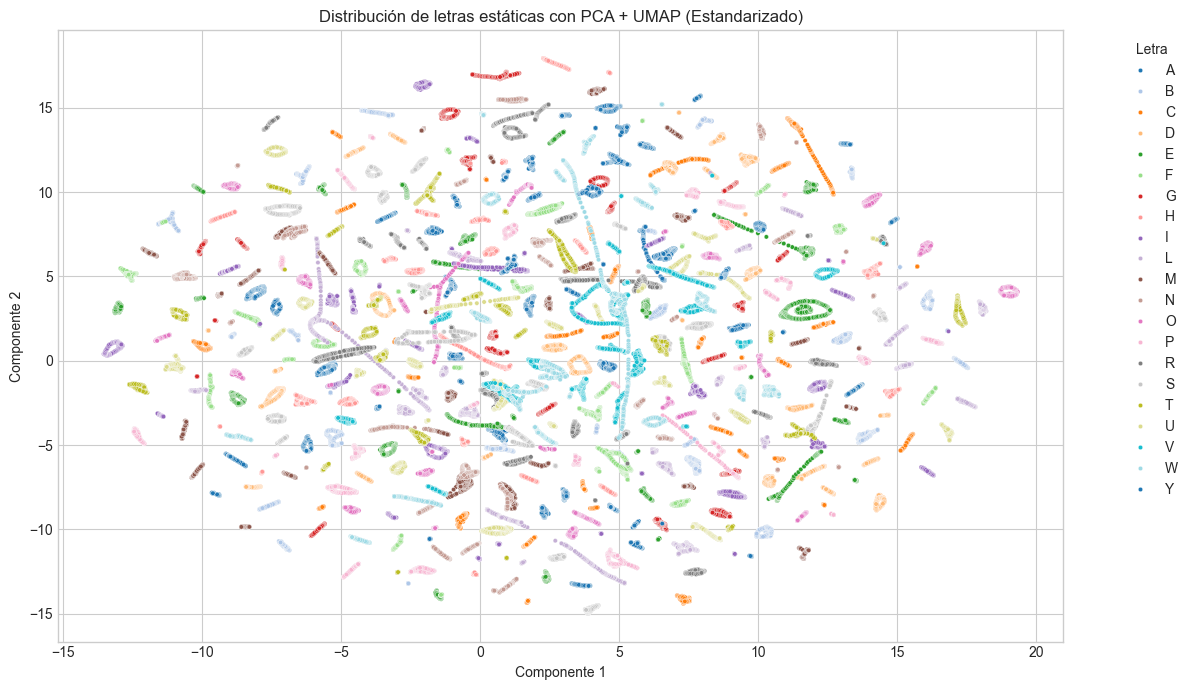

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from tqdm import tqdm
import numpy as np

# ↓↓↓ Parámetros ↓↓↓
target_size = (64, 64)  # Nueva resolución

# Cargar y reducir tamaño de las imágenes
images = []
labels = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    img = cv2.imread(str(here() / row["image_path"]), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img_small = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        images.append(img_small.flatten())
        labels.append(row["label"])

X = np.array(images)
y = np.array(labels)

# 🔹 Estandarización antes de PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔸 Paso 1: PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# 🔸 Paso 2: UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_pca)

# Visualización
df_umap = pd.DataFrame({
    "x": X_umap[:, 0],
    "y": X_umap[:, 1],
    "label": y
})

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_umap, x="x", y="y", hue="label", palette="tab20", s=10)
plt.title("Distribución de letras estáticas con PCA + UMAP (Estandarizado)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Letra", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Conclusiones

- El CSV fue generado correctamente con rutas y etiquetas válidas.
- Todas las imágenes se cargaron sin errores.
- Las clases están balanceadas en cantidad de imágenes.
- Las imágenes tienen buena calidad visual y fondo uniforme.
- Todas las imágenes tienen la misma dimensión (360x360 píxeles).
- Se dispone de un total de 83,264 imágenes para entrenamiento.
- El análisis de reducción de dimensionalidad mediante PCA + UMAP mostró una mejor separabilidad entre clases, lo cual sugiere una buena base para clasificación visual.